# Predicción de Series Temporales NN - Multivariate

## Usaremos Keras y Tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


### Cargamos nuestro Dataset

In [2]:
df = pd.read_csv('Prueba_Unidades.csv', parse_dates=[0], header=None, index_col=0, names=['fecha','unidades'])
df.head()

,unidades
fecha,
2018-04-04,118
2018-04-05,33
2018-04-06,67
2018-04-07,228
2018-04-08,200


In [3]:
print(df.index.min())
print(df.index.max())

2018-04-04 00:00:00
2019-06-21 00:00:00


In [4]:
print(len(df['2018']))
print(len(df['2019']))

241
170


### Cargamos Datos Categóricos: Día y Mes

In [5]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2018-04-04,118,2,4
2018-04-05,33,3,4
2018-04-06,67,4,4
2018-04-07,228,5,4
2018-04-08,200,6,4


In [6]:
df.describe()

,unidades,weekday,month
count,411.000000,411.000000,411.000000
mean,1215.442822,2.963504,6.148418
std,2411.684449,1.994170,3.242231
min,1.000000,0.000000,1.000000
25%,170.500000,1.000000,4.000000
50%,490.000000,3.000000,6.000000
75%,1175.000000,5.000000,9.000000
max,16614.000000,6.000000,12.000000


## Preprocesado de los datos

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
PASOS=7

# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('unidades',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2018-04-11,2.0,4.0,-0.985915,3.0,4.0,-0.996148,4.0,4.0,-0.992054,5.0,...,-0.976043,0.0,4.0,-0.960874,1.0,4.0,-0.952688,2,4,-0.966051
2018-04-12,3.0,4.0,-0.996148,4.0,4.0,-0.992054,5.0,4.0,-0.972672,6.0,...,-0.960874,1.0,4.0,-0.952688,2.0,4.0,-0.966051,3,4,-0.970866
2018-04-13,4.0,4.0,-0.992054,5.0,4.0,-0.972672,6.0,4.0,-0.976043,0.0,...,-0.952688,2.0,4.0,-0.966051,3.0,4.0,-0.970866,4,4,-0.946668
2018-04-14,5.0,4.0,-0.972672,6.0,4.0,-0.976043,0.0,4.0,-0.960874,1.0,...,-0.966051,3.0,4.0,-0.970866,4.0,4.0,-0.946668,5,4,-0.950641
2018-04-15,6.0,4.0,-0.976043,0.0,4.0,-0.960874,1.0,4.0,-0.952688,2.0,...,-0.970866,4.0,4.0,-0.946668,5.0,4.0,-0.950641,6,4,-0.939686


## Dividimos en set de Entrenamiento y Validación

In [9]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(404, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2018-04-11,2.0,4.0,-0.985915,3.0,4.0,-0.996148,4.0,4.0,-0.992054,5.0,...,6.0,4.0,-0.976043,0.0,4.0,-0.960874,1.0,4.0,-0.952688,-0.966051
2018-04-12,3.0,4.0,-0.996148,4.0,4.0,-0.992054,5.0,4.0,-0.972672,6.0,...,0.0,4.0,-0.960874,1.0,4.0,-0.952688,2.0,4.0,-0.966051,-0.970866
2018-04-13,4.0,4.0,-0.992054,5.0,4.0,-0.972672,6.0,4.0,-0.976043,0.0,...,1.0,4.0,-0.952688,2.0,4.0,-0.966051,3.0,4.0,-0.970866,-0.946668
2018-04-14,5.0,4.0,-0.972672,6.0,4.0,-0.976043,0.0,4.0,-0.960874,1.0,...,2.0,4.0,-0.966051,3.0,4.0,-0.970866,4.0,4.0,-0.946668,-0.950641
2018-04-15,6.0,4.0,-0.976043,0.0,4.0,-0.960874,1.0,4.0,-0.952688,2.0,...,3.0,4.0,-0.970866,4.0,4.0,-0.946668,5.0,4.0,-0.950641,-0.939686


In [10]:
# split into train and test sets
values = newReframed.values
n_train_days = 402 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(365, 1, 21) (365,) (39, 1, 21) (39,)


# Creamos el Modelo de Red Neuronal

## Utilizaremos una Red Feedforward

#### Como entradas son 21 columnas (7 pasos por 3 variables)

In [11]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

## Entrenamiento y Resultados

In [12]:
# En pocos segundos vemos una reducción del valor de pérdida tanto del set de entrenamiento como del de validación. 
# original EPOCHS = 40, luego voy modificando
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

W0826 01:30:06.598325  8508 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 01:30:06.763318  8508 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 01:30:06.778318  8508 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 01:30:07.085948  8508 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 7)              154       
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


W0826 01:30:07.889557  8508 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0826 01:30:08.306057  8508 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 365 samples, validate on 39 samples
Epoch 1/40
365/365 [==============================] - 4s 10ms/step - loss: 0.1876 - mean_squared_error: 0.1137 - val_loss: 0.2609 - val_mean_squared_error: 0.2262
Epoch 2/40
365/365 [==============================] - 1s 2ms/step - loss: 0.1213 - mean_squared_error: 0.0831 - val_loss: 0.2707 - val_mean_squared_error: 0.2308
Epoch 3/40
365/365 [==============================] - 1s 2ms/step - loss: 0.1168 - mean_squared_error: 0.0840 - val_loss: 0.2721 - val_mean_squared_error: 0.2315
Epoch 4/40
365/365 [==============================] - 1s 3ms/step - loss: 0.1156 - mean_squared_error: 0.0843 - val_loss: 0.2732 - val_mean_squared_error: 0.2320
Epoch 5/40
365/365 [==============================] - 1s 3ms/step - loss: 0.1146 - mean_squared_error: 0.0843 - val_loss: 0.2721 - val_mean_squared_error: 0.2314
Epoch 6/40
365/365 [==============================] - 1s 2ms/step - loss: 0.1138 - mean_squared_error: 0.0837 - val_loss: 0.2726 - val_mean_squa

## Visualizamos Resultados

39


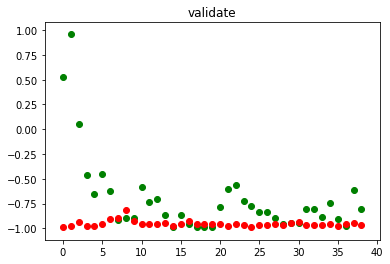

In [13]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

En la gráfica vemos que los puntitos verdes intentan aproximarse a los rojos. Cuanto más cerca ó superpuestos mejor. TIP: Si aumentamos la cantidad de EPOCHS mejora cada vez más

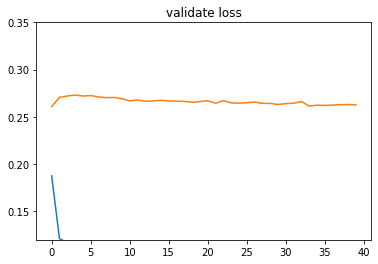

In [14]:
plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

Modelo 2) STMV: En azul el Entrenamiento y naranja el set de Validación

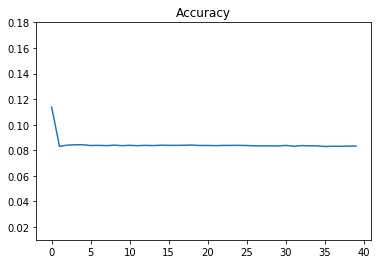

In [15]:
plt.ylim(0.01, 0.18)
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [16]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,12656.999526,123.302187,12533.697339
1,16324.000085,199.103905,16124.896181
2,8788.999797,570.257637,8218.742160
3,4441.999872,183.090196,4258.909676
4,2878.999762,230.567395,2648.432367
5,4559.999969,393.209714,4166.790255
6,3153.000331,808.067443,2344.932888
7,696.000201,871.857394,-175.857193
8,887.999830,1533.301672,-645.301843
9,900.000209,634.361485,265.638723


In [17]:
compara2.describe()

,real,prediccion,diferencia
count,39.000000,39.000000,39.000000
mean,2472.461490,394.560808,2077.900682
std,3315.075139,247.578484,3372.436990
min,88.999758,123.302187,-645.301843
25%,742.500061,263.424114,56.858220
50%,1612.999874,344.778446,1293.259929
75%,3016.000046,413.061732,2496.682627
max,16324.000085,1533.301672,16124.896181


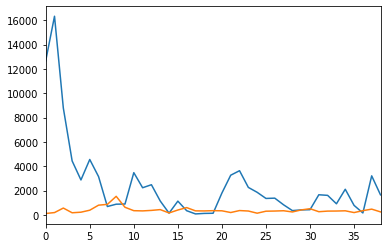

In [18]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Pronóstico

In [19]:
ultimosDias = df['2019-05-16':'2019-05-31']
ultimosDias

,unidades,weekday,month,scaled
fecha,,,,
2019-05-16,8789,3,5,0.057967
2019-05-17,4442,4,5,-0.465358
2019-05-18,2879,5,5,-0.653524
2019-05-19,4560,6,5,-0.451153
2019-05-20,3153,0,5,-0.620538
2019-05-21,696,1,5,-0.916331
2019-05-22,888,2,5,-0.893216
2019-05-23,900,3,5,-0.891771
2019-05-24,3477,4,5,-0.581533


## Preparamos los datos para Test

Y ahora seguiremos el mismo preprocesado de datos que hicimos para el entrenamiento: escalando los valores, llamando a la función series_to_supervised pero esta vez sin incluir la columna de salida «Y» pues es la que queremos hallar. Por eso, verán en el código que hacemos drop() de la última columna.

In [20]:
scaledMerge=ultimosDias.drop('unidades',axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
newReframed.head(7)

[[ 3.          5.          0.05796659]
 [ 4.          5.         -0.4653585 ]
 [ 5.          5.         -0.6535244 ]
 [ 6.          5.         -0.45115274]
 [ 0.          5.         -0.62053812]
 [ 1.          5.         -0.91633058]
 [ 2.          5.         -0.89321619]
 [ 3.          5.         -0.8917715 ]
 [ 4.          5.         -0.5815326 ]
 [ 5.          5.         -0.73057246]
 [ 6.          5.         -0.70083672]
 [ 0.          5.         -0.86167461]
 [ 1.          5.         -0.98158073]
 [ 2.          5.         -0.86299884]
 [ 3.          5.         -0.95762354]
 [ 4.          5.         -0.98940593]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
fecha,,,,,,,,,,,,,,,,,,,,,
2019-05-23,3.0,5.0,0.057967,4.0,5.0,-0.465358,5.0,5.0,-0.653524,6.0,...,-0.451153,0.0,5.0,-0.620538,1.0,5.0,-0.916331,2.0,5.0,-0.893216
2019-05-24,4.0,5.0,-0.465358,5.0,5.0,-0.653524,6.0,5.0,-0.451153,0.0,...,-0.620538,1.0,5.0,-0.916331,2.0,5.0,-0.893216,3.0,5.0,-0.891771
2019-05-25,5.0,5.0,-0.653524,6.0,5.0,-0.451153,0.0,5.0,-0.620538,1.0,...,-0.916331,2.0,5.0,-0.893216,3.0,5.0,-0.891771,4.0,5.0,-0.581533
2019-05-26,6.0,5.0,-0.451153,0.0,5.0,-0.620538,1.0,5.0,-0.916331,2.0,...,-0.893216,3.0,5.0,-0.891771,4.0,5.0,-0.581533,5.0,5.0,-0.730572
2019-05-27,0.0,5.0,-0.620538,1.0,5.0,-0.916331,2.0,5.0,-0.893216,3.0,...,-0.891771,4.0,5.0,-0.581533,5.0,5.0,-0.730572,6.0,5.0,-0.700837
2019-05-28,1.0,5.0,-0.916331,2.0,5.0,-0.893216,3.0,5.0,-0.891771,4.0,...,-0.581533,5.0,5.0,-0.730572,6.0,5.0,-0.700837,0.0,5.0,-0.861675
2019-05-29,2.0,5.0,-0.893216,3.0,5.0,-0.891771,4.0,5.0,-0.581533,5.0,...,-0.730572,6.0,5.0,-0.700837,0.0,5.0,-0.861675,1.0,5.0,-0.981581


De este conjunto «ultimosDias» tomamos sólo la última fila, pues es la que correspondería a la última semana de Mayo y la dejamos en el formato correcto para la red neuronal con reshape:

In [21]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()

(3, 1, 21)
[[[ 2.          5.         -0.89321619  3.          5.
   -0.8917715   4.          5.         -0.5815326   5.
    5.         -0.73057246  6.          5.         -0.70083672
    0.          5.         -0.86167461  1.          5.
   -0.98158073]]

 [[ 3.          5.         -0.8917715   4.          5.
   -0.5815326   5.          5.         -0.73057246  6.
    5.         -0.70083672  0.          5.         -0.86167461
    1.          5.         -0.98158073  2.          5.
   -0.86299884]]

 [[ 4.          5.         -0.5815326   5.          5.
   -0.73057246  6.          5.         -0.70083672  0.
    5.         -0.86167461  1.          5.         -0.98158073
    2.          5.         -0.86299884  3.          5.
   -0.95762354]]]


Ahora crearemos una función para ir «rellenando» el desplazamiento que hacemos por cada predicción. Esto es porque queremos predecir los 7 primeros días de Junio. Entonces para el 1 de Junio, ya tenemos el set con los últimos 7 días de Mayo. Pero para pronosticar el 2 de Junio necesitamos los 7 días anteriores que INCLUYEN al 1 de Junio y ese valor, lo obtenemos en nuestra predicción anterior. Y así hasta el 7 de Junio.

In [22]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

## Pronóstico para la "próxima semana"

In [23]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 2.          5.         -0.89321619  3.          5.
   -0.8917715   4.          5.         -0.5815326   5.
    5.         -0.73057246  6.          5.         -0.70083672
    0.          5.         -0.86167461  1.          5.
   -0.98158073]]

 [[ 3.          5.         -0.8917715   4.          5.
   -0.5815326   5.          5.         -0.73057246  6.
    5.         -0.70083672  0.          5.         -0.86167461
    1.          5.         -0.98158073  2.          5.
   -0.86299884]]

 [[ 4.          5.         -0.5815326   5.          5.
   -0.73057246  6.          5.         -0.70083672  0.
    5.         -0.86167461  1.          5.         -0.98158073
    2.          5.         -0.86299884  3.          5.
   -0.95762354]]]
pred 1 [[[ 3.          5.         -0.8917715   4.          5.
   -0.5815326   5.          5.         -0.73057246  6.
    5.         -0.70083672  0.          5.         -0.86167461
    1.          5.         -0.98158073  5.         12.
   -0.95082486]]

 [

## Re-Convertimos los resultados

Ya casi lo tenemos… Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala «real» de unidades vendidas. Entonces vamos a «re-transformar» los datos con el objeto «scaler» que creamos antes.

In [24]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.95082486], dtype=float32), array([-0.9828278], dtype=float32), array([-0.9618347], dtype=float32), array([-0.9610579], dtype=float32), array([-0.9607679], dtype=float32), array([-0.9968632], dtype=float32), array([-0.9959283], dtype=float32)]


array([[409.47345091],
       [143.64114099],
       [318.01994736],
       [324.47266377],
       [326.88135442],
       [ 27.05605722],
       [ 34.82179472]])

## Visualizamos el pronóstico

Ya podemos crear un nuevo DataFrame Pandas por si quisiéramos guardar un nuevo csv con el pronóstico. Y lo visualizamos.

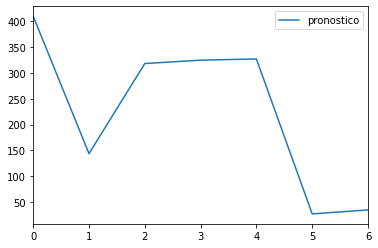

In [25]:
prediccion1SemanaJunio = pd.DataFrame(inverted)
prediccion1SemanaJunio.columns = ['pronostico']
prediccion1SemanaJunio.plot()
prediccion1SemanaJunio.to_csv('pronostico_multivariate_U.csv')

In [26]:
prediccion1SemanaJunio

,pronostico
0,409.473451
1,143.641141
2,318.019947
3,324.472664
4,326.881354
5,27.056057
6,34.821795


A partir de los últimos 7 días de Mayo 2019 y utilizando nuestra red neuronal, hicimos el siguiente pronóstico de venta de unidades para la primer semana de Junio.

Para Probar, alterando parámetros del ejercicio:

Variar la cantidad de EPOCHS Probar otro optimizador distinto a Adam, ó configurar valores distintos de Learning Rate. Cambiar la arquitectura de la Red Neuronal: Cambiar la cantidad de Neuronas de la capa oculta. Agregar más capas ocultas Probar utilizando más de 7 días previos para predecir. O probar con menos días. Se puede intentar predecir más de 1 día por vez (sin iterar el resultado como hice con la función agregarNuevoValor() )

## Agregamos el resultado en el dataset

In [27]:
i=0
for fila in prediccion1SemanaJunio.pronostico:
    i=i+1
    ultimosDias.loc['2019-06-0' + str(i) + ' 00:00:00'] = fila
    print(fila)
ultimosDias.tail(14)

409.47345090811336
143.64114098723363
318.0199473563081
324.4726637669443
326.8813544243329
27.05605721568635
34.82179472054555


C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\pandas\core\indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,unidades,weekday,month,scaled
fecha,,,,
2019-05-25 00:00:00,2239.000000,5.000000,5.000000,-0.730572
2019-05-26 00:00:00,2486.000000,6.000000,5.000000,-0.700837
2019-05-27 00:00:00,1150.000000,0.000000,5.000000,-0.861675
2019-05-28 00:00:00,154.000000,1.000000,5.000000,-0.981581
2019-05-29 00:00:00,1139.000000,2.000000,5.000000,-0.862999
2019-05-30 00:00:00,353.000000,3.000000,5.000000,-0.957624
2019-05-31 00:00:00,89.000000,4.000000,5.000000,-0.989406
2019-06-01 00:00:00,409.473451,409.473451,409.473451,409.473451
2019-06-02 00:00:00,143.641141,143.641141,143.641141,143.641141
